In [485]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import quandl
import statistics
#import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM, Dense

# free data capture limits for some sources
# Get stock data from tiingo
# Ge treaury data from Quandl
import requests
nan=np.nan

In [486]:
DBGmode = 0
#st_date = '2020-7-1'
#en_date = '2020-9-11'
WritetoFile = 0

pd.set_option('display.max_rows', 15)
ticker = 'MSFT'
st_date = '2019-9-17'
en_date = '2020-9-16'

timestep = 3
TrainPCT = 0.85

ADDUS10Y = 0

ADDXMA = 0
xmasmall = 7
xmalong = 14

ADDRSI = 1
RSIwindow = 21

epochval = 20

In [487]:
us10y_data = quandl.get("FRED/DGS10", start_date=st_date, end_date=en_date, api_key = 'tNjFxT5wYAG7nbemafxi')
us10y_data=us10y_data.reset_index()
us10y_data.rename(columns = {'Value':'US10Y'}, inplace = True) 

if DBGmode==1:
    us10y_data

In [488]:
for row in range(0,len(us10y_data)):
    us10y_data['Date'][row]=str(us10y_data['Date'][row])[:10]+'T00:00:00.000Z'
us10y_data=us10y_data.set_index('Date')

if DBGmode==1:
    us10y_data

<ipython-input-488-83275a74f87b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us10y_data['Date'][row]=str(us10y_data['Date'][row])[:10]+'T00:00:00.000Z'
/Users/prasannaob/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [489]:
def get_stock_data(stock_symbol, start_date, end_date):
    base_url = f'https://api.tiingo.com/tiingo/daily/{stock_symbol}/prices?'
    token = '59e2dfca5859e44a55ef766a8f81aab1ab8a80e8'
    payload = {
        'startDate': start_date,
        'endDate': end_date,
        'token': token
    }
    response = requests.get(base_url, params=payload)
    return response

In [490]:
response = get_stock_data(ticker, st_date, en_date)

if DBGmode == 1:
    print(response.url)
    print(response.json())

In [491]:
def parse_data(data_response):
    json_data = data_response.json()
    dates = []
    closes =[]
    opens = []
    highs = []
    lows = []
    vols = []
    for json_object in json_data:
        dates.append(json_object['date'])
        closes.append(json_object['close'])
        opens.append(json_object['open'])
        highs.append(json_object['high'])
        lows.append(json_object['low'])
        vols.append(json_object['volume'])
    return dates, closes, opens, highs, lows, vols

In [492]:
dates, closes, opens, highs, lows, vols = parse_data(response)

if DBGmode == 1:
    print(dates, closes)

In [493]:
#**** Define New Column Label here
datastock = pd.DataFrame(columns = ['Close'], index = dates)
dfindex = datastock.index
dfindex.name = 'Date'

In [494]:
#**** ADD New Column Data here
datastock['Close']=closes
#datastock['Volume']=vols

if DBGmode == 1:
    datastock

In [495]:
if DBGmode == 1:
    plt.plot(datastock['Close'], label=ticker+' Closes')
    plt.legend()
    plt.show()

In [496]:
print('Total Stock Rows = ', len(datastock))
print('Total US10Y Rows = ', len(us10y_data))

if ADDUS10Y==1:
    #****APPEND US10Y data here to a separate column in a new dataframe
    data=pd.concat([datastock, us10y_data], axis=1, sort=False)

    #fill US10Y NaN with previous value
    data['US10Y'].fillna(method='ffill', inplace=True)

else:
    data=datastock
    
data

Total Stock Rows =  253
Total US10Y Rows =  251


,Close
Date,
2019-09-17T00:00:00.000Z,137.39
2019-09-18T00:00:00.000Z,138.52
2019-09-19T00:00:00.000Z,141.07
2019-09-20T00:00:00.000Z,139.44
2019-09-23T00:00:00.000Z,139.14
...,...
2020-09-10T00:00:00.000Z,205.37
2020-09-11T00:00:00.000Z,204.03
2020-09-14T00:00:00.000Z,205.41


In [497]:
#Add XMA here

if ADDXMA == 1:
    #Enter SMA Data - defined at the top
    #xmasmall=5
    #xmalong=9
    #data['Close-XMA5'] = data.iloc[:,0].rolling(window=smasmall).mean()
    #data['Close-XMA9'] = data.iloc[:,0].rolling(window=smalong).mean()

    #Enter EMA Data - defined at the top
    #xmasmall=7
    #xmalong=14
    data['Close-XMA'+str(xmasmall)] = data.iloc[:,0].ewm(span=xmasmall, adjust=False).mean()
    data['Close-XMA'+str(xmalong)] = data.iloc[:,0].ewm(span=xmalong, adjust=False).mean()

    droprow=xmalong
    data.drop(data.index[0:droprow], inplace = True)

In [498]:
def computeRSI (data, time_window):
    diff = data.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    
    # check pandas documentation for ewm
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
    # values are related to exponential decay
    # we set com=time_window-1 so we get decay alpha=1/time_window
    up_chg_avg   = up_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    down_chg_avg = down_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi

In [499]:
#Add RSI here
if ADDRSI == 1:
    data['Close-RSI'+str(RSIwindow)] = computeRSI(data['Close'], RSIwindow)
    data.drop(data.index[0:RSIwindow], inplace = True)

In [500]:
data_noofcols = len(data.columns)
print('Number of data columns = ', data_noofcols)

Number of data columns =  2


In [501]:
data

,Close,Close-RSI21
Date,,
2019-10-16T00:00:00.000Z,140.41,56.256947
2019-10-17T00:00:00.000Z,139.69,54.095520
2019-10-18T00:00:00.000Z,137.41,47.967714
2019-10-21T00:00:00.000Z,138.43,50.596504
2019-10-22T00:00:00.000Z,136.37,45.700311
...,...,...
2020-09-10T00:00:00.000Z,205.37,46.394857
2020-09-11T00:00:00.000Z,204.03,45.671714
2020-09-14T00:00:00.000Z,205.41,46.572217


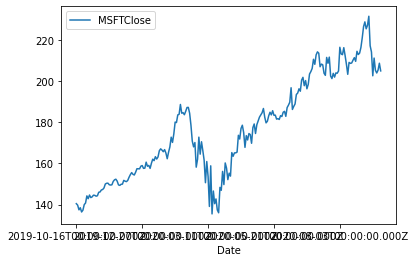

In [502]:
plt.figure()
data['Close'].plot(label=ticker+'Close')
if ADDXMA==1:
    data['Close-XMA'+str(xmasmall)].plot(label=ticker+'EMA'+str(xmasmall))
    data['Close-XMA'+str(xmalong)].plot(label=ticker+'EMA'+str(xmalong))
plt.legend()
if ADDUS10Y==1:
    data['US10Y'].plot(secondary_y=True, label='US10Y')
plt.legend()
#plt.plot(data['Close'], label=ticker+' Closes')
#plt.plot(data['US10Y'], label='US10Y')
plt.show()

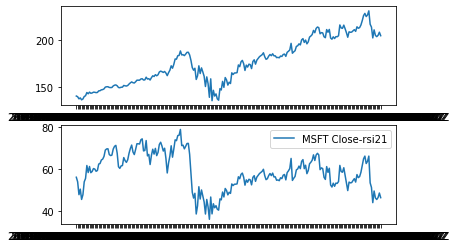

In [503]:
fig, axs = plt.subplots(2,1)
axs[0].plot(data['Close'], label=ticker+' Closes')
if ADDXMA==1:
    axs[0].plot(data['Close-XMA'+str(xmasmall)], label=ticker+' Close-ema'+str(xmasmall))
    axs[0].plot(data['Close-XMA'+str(xmalong)], label=ticker+' Close-ema'+str(xmalong))
    plt.legend()
if ADDRSI==1:
    axs[1].plot(data['Close-RSI'+str(RSIwindow)], label=ticker+' Close-rsi'+str(RSIwindow))
    plt.legend()
plt.show()

In [504]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

print('Length of scaled_data = ', len(scaled_data))
print(scaled_data)

Length of scaled_data =  232
[[0.05185493 0.46806092]
 [0.04437286 0.41750892]
 [0.02067962 0.27419019]
 [0.03127923 0.33567303]
 [0.00987218 0.22115958]
 [0.01891302 0.27341447]
 [0.0469708  0.41738356]
 [0.0551803  0.45501779]
 [0.09113582 0.59884005]
 [0.07700301 0.52046035]
 [0.09550036 0.58773136]
 [0.08261457 0.51847664]
 [0.08625169 0.5321886 ]
 [0.09487686 0.56470852]
 [0.0939416  0.55927611]
 [0.08978489 0.53446763]
 [0.09186324 0.54324238]
 [0.10952925 0.61496712]
 [0.11108802 0.62106663]
 [0.12106412 0.65995091]
 [0.12355814 0.66958879]
 [0.13135197 0.69970074]
 [0.15120025 0.77034503]
 [0.1550452  0.78319831]
 [0.15556479 0.78498505]
 [0.14756313 0.72096677]
 [0.14610828 0.70931157]
 [0.14725138 0.71407479]
 [0.16429388 0.78173354]
 [0.1726073  0.81201997]
 [0.17562091 0.82287913]
 [0.16585264 0.73665626]
 [0.14683571 0.58545333]
 [0.14434168 0.56686335]
 [0.14995324 0.59434553]
 [0.15078458 0.59847433]
 [0.1696976  0.68691986]
 [0.16564481 0.65345454]
 [0.1632547  0.633453

In [505]:
train_length = int(len(scaled_data) * TrainPCT)
test_length = len(scaled_data) - train_length
train_data = scaled_data[0:train_length,:]
test_data = scaled_data[train_length:len(scaled_data),:]

if DBGmode == 1:
    print('scaled_data length =', len(scaled_data))
    print('train_length = ', train_length)
    print('test_length = ', test_length)
    print(train_data)
    print(test_data)

In [506]:
def create_dataset(dataset, noofcols, timestep=1):
    data_x, data_y = [], []
    #for i in range(len(dataset) - timestep - 1):
        #data_x.append(dataset[i:(i+timestep),0])
        #data_y.append(dataset[i+timestep,0])
    for i in range(len(dataset) - timestep):
        data_x.append(dataset[i:(i+timestep),0:noofcols])
        data_y.append(dataset[i+timestep,0])
    #It has been shown that Numpy arrays need 4 times less memory compared to Python lists
    return np.array(data_x), np.array(data_y)

In [507]:
train_x, train_y = create_dataset(train_data, data_noofcols, timestep)
test_x, test_y = create_dataset(test_data, data_noofcols, timestep)

if DBGmode == 1:
    print(train_x)

In [508]:
if DBGmode == 1:
    print(train_y)

In [509]:
print('train_x shape = ', train_x.shape)
print('test_x shape = ', test_x.shape)
print('train_y shape = ', train_y.shape)
print('test_y shape = ', test_y.shape)

train_x shape =  (194, 3, 2)
test_x shape =  (32, 3, 2)
train_y shape =  (194,)
test_y shape =  (32,)


In [510]:
#train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[data_noofcols]))
#test_x = np.reshape(test_x, (test_x.shape[0], 1, test_x.shape[data_noofcols]))

#Minimum 2
#train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[2]))
#test_x = np.reshape(test_x, (test_x.shape[0], 1, test_x.shape[2]))

if DBGmode == 1:
    print(train_x)

In [511]:
#optimizer = 'adam' 'SGD' 'RMSprop' 'adadelta' 'adagrad' 'adamax' 'nadam' 'ftrl'
#activation = 'sigmoid' 'linear' relu' 'softmax' 'softplus' 'softsign' 'tanh' selu' 'elu' 'exponential' 
#loss = 'binary_crossentropy' 'mean_squared_error'

model = Sequential()
#model.add(LSTM(256, input_shape=(1,data_noofcols)))
model.add(LSTM(256, input_shape=(timestep,data_noofcols)))
model.add(Dense(1, activation='sigmoid'))
#model.add(Dense(6, input_dim=6, activation='relu'))
#model.add(Dense(6, activation='relu'))
#model.add(Dense(1, activation=None))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 256)               265216    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 257       
Total params: 265,473
Trainable params: 265,473
Non-trainable params: 0
_________________________________________________________________
None


In [512]:
model.fit(train_x, train_y, epochs=epochval, batch_size=1, verbose=1)
score = model.evaluate(train_x, train_y, verbose=0)
print('Keras model loss = ', score[0])
print('Keras model accuracy = ', score[1])

Epoch 1/20
194/194 [==============================] - 0s 2ms/step - loss: 0.0251 - accuracy: 0.0052
Epoch 2/20
194/194 [==============================] - 0s 2ms/step - loss: 0.0036 - accuracy: 0.0052
Epoch 3/20
194/194 [==============================] - 0s 2ms/step - loss: 0.0038 - accuracy: 0.0052
Epoch 4/20
194/194 [==============================] - 0s 2ms/step - loss: 0.0033 - accuracy: 0.0052
Epoch 5/20
194/194 [==============================] - 0s 2ms/step - loss: 0.0033 - accuracy: 0.0052
Epoch 6/20
194/194 [==============================] - 0s 2ms/step - loss: 0.0031 - accuracy: 0.0052
Epoch 7/20
194/194 [==============================] - 0s 2ms/step - loss: 0.0034 - accuracy: 0.0052
Epoch 8/20
194/194 [==============================] - 0s 2ms/step - loss: 0.0031 - accuracy: 0.0052
Epoch 9/20
194/194 [==============================] - 0s 2ms/step - loss: 0.0031 - accuracy: 0.0052
Epoch 10/20
194/194 [==============================] - 0s 2ms/step - loss: 0.0032 - accuracy: 0.0052

In [513]:
train_predictions = model.predict(train_x)
test_predictions = model.predict(test_x)

if DBGmode == 1:
    print(train_predictions)

In [514]:
# create empty table with data_noofcols fields
train_predictions_like = np.zeros(shape=(len(train_predictions), data_noofcols) )
# put the predicted values in the right field
train_predictions_like[:,0] = train_predictions[:,0]
# inverse transform and then select the right field
train_predictions = scaler.inverse_transform(train_predictions_like)[:,0]

# create empty table with 2 fields
test_predictions_like = np.zeros(shape=(len(test_predictions), data_noofcols) )
# put the predicted values in the right field
test_predictions_like[:,0] = test_predictions[:,0]
# inverse transform and then select the right field
test_predictions = scaler.inverse_transform(test_predictions_like)[:,0]

In [515]:
if DBGmode == 1:
    print(train_predictions)
    print(test_predictions)

In [516]:
#train_predict_plot = np.empty_like(scaled_data[:,0])
train_predict_plot = scaled_data[:,0]
train_predict_plot[:] = np.nan
train_predict_plot[timestep:len(train_predictions)+timestep] = train_predictions

In [517]:
if DBGmode==1:
    print(test_predictions)

In [518]:
test_predict_plot = np.empty_like(scaled_data[:,0])
test_predict_plot[:] = np.nan
test_predict_plot[
    len(train_predictions)+timestep+timestep:len(scaled_data)] = test_predictions

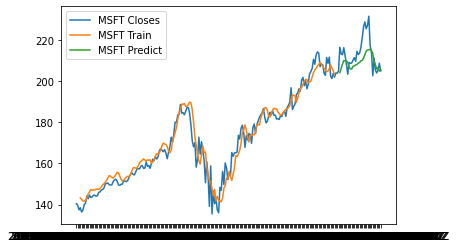

In [519]:
plt.plot(data.Close, label = ticker+' Closes')
plt.plot(train_predict_plot, label = ticker+' Train')
plt.plot(test_predict_plot, label = ticker+' Predict')
plt.legend()
plt.show()

In [520]:
print('Number of data[Close] rows = ', len(data['Close']))
print('Length of Train data = ', len(train_predictions))
print('Length of test data = ', len(test_predictions))

Number of data[Close] rows =  232
Length of Train data =  194
Length of test data =  32


In [521]:
data['AITrain'] = train_predict_plot
data['AITest'] = test_predict_plot
data

,Close,Close-RSI21,AITrain,AITest
Date,,,,
2019-10-16T00:00:00.000Z,140.41,56.256947,NaN,NaN
2019-10-17T00:00:00.000Z,139.69,54.095520,NaN,NaN
2019-10-18T00:00:00.000Z,137.41,47.967714,NaN,NaN
2019-10-21T00:00:00.000Z,138.43,50.596504,143.235006,NaN
2019-10-22T00:00:00.000Z,136.37,45.700311,142.556455,NaN
...,...,...,...,...
2020-09-10T00:00:00.000Z,205.37,46.394857,NaN,207.979887
2020-09-11T00:00:00.000Z,204.03,45.671714,NaN,205.922982
2020-09-14T00:00:00.000Z,205.41,46.572217,NaN,206.711184


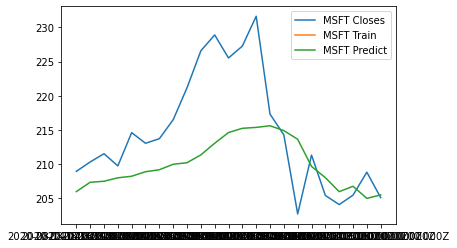

In [522]:
plt.plot(data.Close[-timestep-20:], label = ticker+' Closes')
plt.plot(train_predict_plot[-timestep-20:], label = ticker+' Train')
plt.plot(test_predict_plot[-timestep-20:], label = ticker+' Predict')
plt.legend()
plt.show()

In [523]:
data['Abs%Err']=nan
data['DirErr']=nan

In [524]:
#-----STOCK PRICE PREDICTION METRIC-----
for i in range(len(train_predictions)+timestep+timestep,len(scaled_data)):
    data['Abs%Err'][i]=100*(data['AITest'][i]-data['Close'][i])/data['Close'][i]

#-----DIRECTION PREDICTION METRIC-----
for i in range(len(train_predictions)+timestep+timestep+1,len(scaled_data)):
    parity=0
    if ((data['Close'][i] - data['Close'][i-1])*(data['AITest'][i] - data['AITest'][i-1])) > 0:
        data['DirErr'][i]=0
        parity=1
    if parity==0:
        data['DirErr'][i]=1

if DBGmode==1:
    print('Train length = ', len(train_predictions)+timestep)
    print('Total length = ', len(scaled_data))
    ch=len(train_predictions)+timestep+timestep+1
    print('data[Close][i]   = ', data['Close'][ch])
    print('data[Close][i-1] = ', data['Close'][ch-1])
    print('data[AITest][i]= ', data['AITest'][ch])
    print('data[AITest][i-1]= ', data['AITest'][ch-1])
    print('data[DirErr][i]  = ', data['DirErr'][ch])

In [525]:
if DBGmode==1:
    print(data['DirErr'][len(train_predictions)+timestep+timestep+1:len(scaled_data)])
    print(data['Abs%Err'][len(train_predictions)+timestep+timestep:len(scaled_data)])

In [526]:
Tot_test_error = sum(data['DirErr'][len(train_predictions)+timestep+timestep+1:len(scaled_data)])
Tot_test_len = sum(data['DirErr'].notnull())
Test_DirAcc = 100*(Tot_test_len - Tot_test_error) / Tot_test_len
print('timestep=', timestep)
print('')
print('----DIRECTION-----')
print('Total Test Errors = ', Tot_test_error)
print('Total Test Elements = ', Tot_test_len)
print('Test Direction Predict Accuracy = ', Test_DirAcc)
print('')
print('----STOCK PRICE PREDICTION-----')
len(train_predictions)+timestep,len(scaled_data)-timestep
print('Max % Price Error = ', max(data['Abs%Err'][len(train_predictions)+timestep+timestep:len(scaled_data)]))
print('Min % Price Error = ', min(data['Abs%Err'][len(train_predictions)+timestep+timestep:len(scaled_data)]))
print('Average % Price Error = ', statistics.mean(data['Abs%Err'][len(train_predictions)+timestep+timestep:len(scaled_data)]))

timestep= 3

----DIRECTION-----
Total Test Errors =  11.0
Total Test Elements =  31
Test Direction Predict Accuracy =  64.51612903225806

----STOCK PRICE PREDICTION-----
Max % Price Error =  5.4028019498746005
Min % Price Error =  -7.037052053523162
Average % Price Error =  -1.8803045521263662


In [527]:
if WritetoFile == 1:
    data.to_csv(ticker+'_predict.csv')
    print('Wrote to file')

In [528]:
if DBGmode == 0:
    pd.set_option('display.max_rows', data.shape[0]+1)
    data

print('timestep=', timestep)
data.tail(timestep+10)

timestep= 3


,Close,Close-RSI21,AITrain,AITest,Abs%Err,DirErr
Date,,,,,,
2020-08-28T00:00:00.000Z,228.91,66.321816,NaN,213.023927,-6.939877,0.0
2020-08-31T00:00:00.000Z,225.53,62.784692,NaN,214.592444,-4.849712,1.0
2020-09-01T00:00:00.000Z,227.27,63.827476,NaN,215.214406,-5.304525,0.0
2020-09-02T00:00:00.000Z,231.65,66.321710,NaN,215.348669,-7.037052,0.0
2020-09-03T00:00:00.000Z,217.30,53.606043,NaN,215.589364,-0.787223,1.0
2020-09-04T00:00:00.000Z,214.25,51.406469,NaN,214.879060,0.293610,0.0
2020-09-08T00:00:00.000Z,202.66,44.174318,NaN,213.609318,5.402802,0.0
2020-09-09T00:00:00.000Z,211.29,49.706291,NaN,209.627672,-0.786752,1.0
2020-09-10T00:00:00.000Z,205.37,46.394857,NaN,207.979887,1.270822,0.0
